In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import datetime

## Prepare the data

In [23]:
# Dataset Parameters
root = './dataset/'
batch_size = 16
img_height = 256
img_width = 256
seed = 42

In [24]:
# importing the training split
train_ds = keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# importing the validation split
val_ds = keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4757 files belonging to 29 classes.
Using 951 files for validation.


# Hyperparameter initialisation and Dataset finalization

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 15
image_size = 56  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
# testing for class names presence
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Chickenpox', 'Cowpox', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'HFMD', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Healthy', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Measles', 'Melanoma Skin Cancer Nevi and Moles', 'Monkeypox', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
29


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


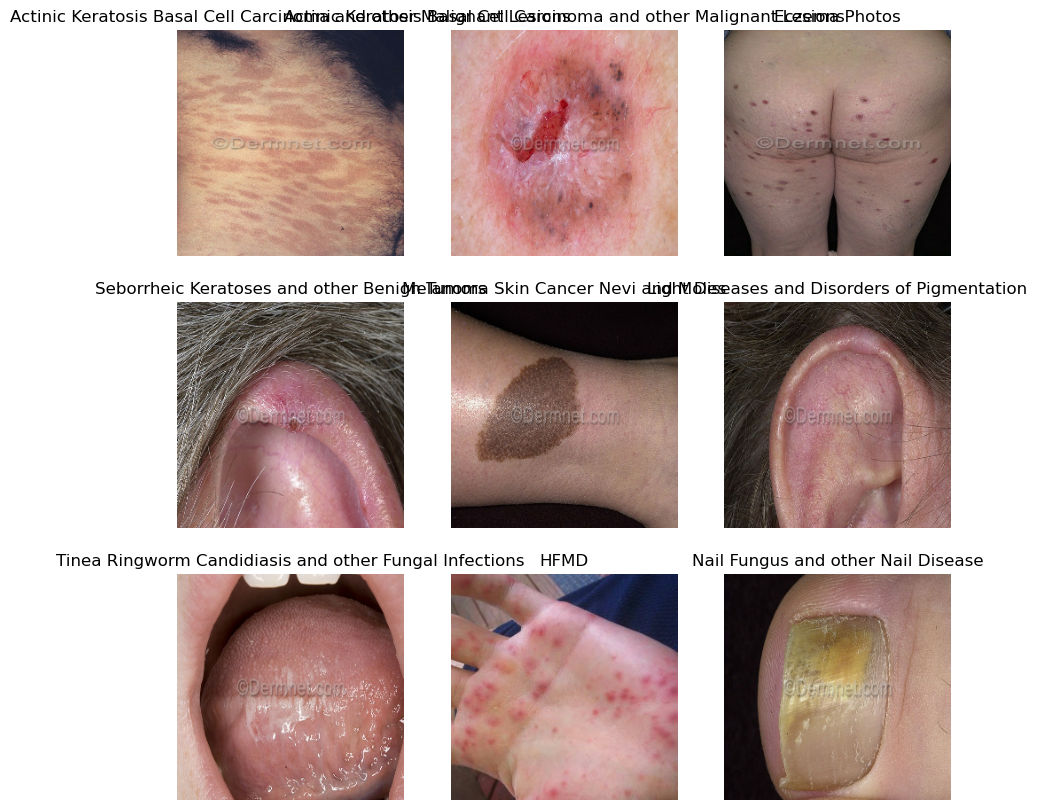

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
%reload_ext tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(128, 3, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Conv2D(64, 3, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Conv2D(32, 3, (2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(16 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Dense(8 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Dense(2 * num_classes, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=125,
  callbacks=[tensorboard_callback]
)

Epoch 1/25


2023-09-22 19:21:06.578160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-09-22 19:21:07.736871: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 19:21:07.880712: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fea41d55b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 19:21:07.880759: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2023-09-22 19:21:07.889254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-22 19:21:08.134651: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 19:21:08.204172: I ./tensorflow/compiler/jit/devic

238/238 [==============================] - 17s 44ms/step - loss: 3.2096 - accuracy: 0.0825 - val_loss: 3.1173 - val_accuracy: 0.0757
Epoch 2/25
238/238 [==============================] - 10s 42ms/step - loss: 3.1097 - accuracy: 0.0983 - val_loss: 3.0772 - val_accuracy: 0.1167
Epoch 3/25
238/238 [==============================] - 11s 46ms/step - loss: 3.0577 - accuracy: 0.1251 - val_loss: 3.0634 - val_accuracy: 0.1367
Epoch 4/25
238/238 [==============================] - 10s 42ms/step - loss: 2.9958 - accuracy: 0.1414 - val_loss: 3.0478 - val_accuracy: 0.1430
Epoch 5/25
238/238 [==============================] - 11s 45ms/step - loss: 2.9109 - accuracy: 0.1668 - val_loss: 3.0593 - val_accuracy: 0.1388
Epoch 6/25
238/238 [==============================] - 11s 45ms/step - loss: 2.7652 - accuracy: 0.1955 - val_loss: 3.2130 - val_accuracy: 0.1399
Epoch 7/25
238/238 [==============================] - 10s 40ms/step - loss: 2.5099 - accuracy: 0.2730 - val_loss: 3.5388 - val_accuracy: 0.1493
Epo

In [ ]:
model.evaluate(val_ds, callbacks=[tensorboard_callback])

60/60 [==============================] - 2s 28ms/step - loss: 12.5982 - accuracy: 0.1220


[12.59816837310791, 0.12197686731815338]

In [ ]:
images = []
labels = []

for x, y in val_ds.unbatch():
    images.append(x)
    labels.append(np.array(y).item())

In [ ]:
test = np.array(images)

In [ ]:
y_pred = (model.predict(test)).argmax(axis=1)

30/30 [==============================] - 1s 13ms/step


In [ ]:
y_pred

array([12,  1, 22, 12,  7, 27, 17,  9,  6, 17, 27, 17, 17, 23, 22, 20,  1,
        0,  1,  0, 21, 12,  0,  9, 22, 24, 12,  1, 18, 22, 18, 13, 21, 12,
       26, 17, 20, 28, 28, 13,  0,  9, 11, 22,  8,  7, 22,  7, 16, 18,  9,
        2, 24,  6, 28,  1,  3, 22, 20,  5, 28,  9,  1, 20,  1,  2, 24, 17,
       20, 22,  9, 20, 28, 12, 24, 28,  0, 28,  6,  1, 17, 18, 20, 22, 13,
        5,  0, 27, 22,  5,  0,  9, 24, 22, 28, 23, 20,  5,  7, 24,  7, 18,
       26, 17, 17, 17, 28,  5,  7,  2, 28,  8, 11, 24, 20,  9, 24, 20,  9,
        9, 18, 12,  7, 17, 22, 20, 15, 26,  6, 16,  7, 22, 20,  1, 17, 16,
        0,  9, 23, 18, 28, 22,  7, 18,  7, 22, 23, 12,  4, 28,  9,  7,  4,
       28, 20, 28, 14, 21,  9, 17, 28,  7, 25,  0, 26, 17, 23,  7, 18, 17,
       17, 20, 20, 20,  7, 12, 24,  7, 13,  0,  0,  1, 17, 19, 20,  1, 18,
        0, 28, 13,  3, 21, 16, 20,  1, 18, 25, 20,  9, 28,  7, 12, 21, 12,
       24, 22, 26, 20,  8,  1,  3,  9,  5,  4, 14, 18, 28, 12, 12, 22,  1,
        2, 20, 28, 20,  0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("==============TEST RESULTS============")
# print('Confusion Matrix')
# print(confusion_matrix(labels, y_pred))
print('\nClassification Report')
print(classification_report(labels, y_pred, target_names=val_ds.class_names))

==============TEST RESULTS============

Classification Report
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.17      0.19      0.18        52
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.14      0.19      0.16        57
                                          Atopic Dermatitis Photos       0.00      0.00      0.00        23
                                            Bullous Disease Photos       0.08      0.05      0.06        21
                Cellulitis Impetigo and other Bacterial Infections       0.12      0.06      0.08        16
                                                        Chickenpox       0.05      0.07      0.06        14
                                                            Cowpox       0.00      0.00      0.00         3
                                                     Eczema Photos       

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 85, 85, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        73792     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 464)               2509776   
                                                                 
 dense_1 (Dense)             (None, 232)               1

In [ ]:
lmao = model.history

<Figure size 640x480 with 0 Axes>

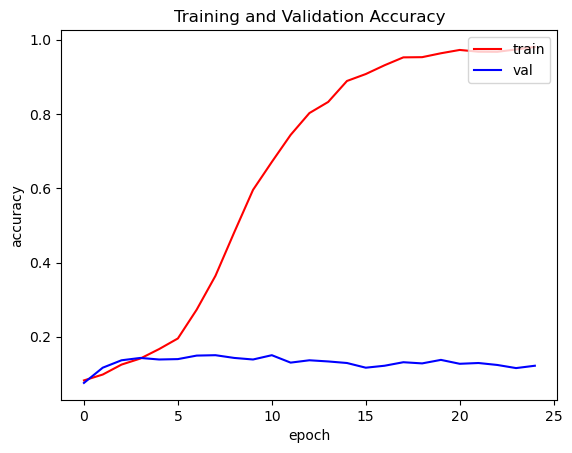

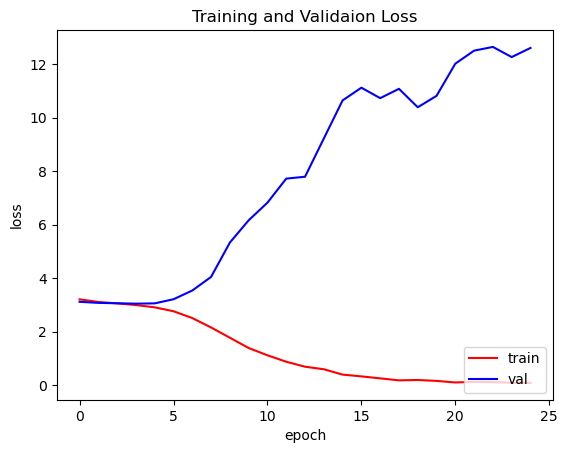

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = fit.history['accuracy']
val_acc = fit.history['val_accuracy']
loss = fit.history['loss']
val_loss = fit.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.title('Training and Validaion Loss')
plt.figure()

In [ ]:
model.save('./models/cnn-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5')

/home/andyd/miniconda3/envs/nlp/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
